# Create a subset of NACTI training data

## Import libraries and create helper functions

In [1]:
import json
import pandas as pd
from shutil import copyfile
import os
import re
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
# Use regex to extract approximate location naming conventions from file names
def get_cam_location(file_id):
    '''
    This function uses a regex expressions to try and determine individual
    camera locations based on the file name. Several assumptions are made
    and it is not expected to be 100% accurate.
    
    Some cameras that may have biased results are flagged as 'ignore' and
    filtered out at a later point in time
    
    args:
      file_id - File name from Nacti dataset
    returns:
      camera_location 
    '''
    
    if re.search('Ivan',file_id):
        return re.findall('(.+)_img\d+.jpg', file_id.lower())[0]
    elif re.search('WA-Site', file_id):
        return re.findall('(.+)_\d+\.jpg', file_id.lower())[0]
    elif re.search('SWTB',file_id):
        return re.findall('(.+)_img\d+.jpg', file_id.lower())[0]
    elif re.search('^ACAM', file_id):
        return re.findall('(^acam\d+)_', file_id.lower())[0]
    elif re.search('^CA\-\d{2}', file_id):
        return re.findall('^ca\-\d{2}', file_id.lower())[0]
    elif re.search('Challenge_Bait', file_id):
        return 'ignore'
    elif re.search('^FL\-\d{2}', file_id):
        return re.findall('^fl\-\d{2}', file_id.lower())[0]
    elif re.search('^Image', file_id):
        return 'ignore'
    elif re.search('^LandfillBaitStations', file_id):
        return re.findall('(^landfillbaitstations\d+_acam\d+)_', file_id.lower())[0]
    elif re.search('^MixedBaitStations', file_id):
        return re.findall('(^mixedbaitstations\d+_acam\d+)_', file_id.lower())[0]
    elif re.search('^TAG', file_id):
        return re.findall('^tag\-[a-z]{2}\d{2}', file_id.lower())[0]
    elif re.search('Kerr', file_id):
        return 'ignore'
    else:
        return 'other'
    
# Tag photos as either empty or animal
def empty_v_animal_label(label):
    '''
    When presented a label, either return empty if empty
    or animal if a species name is listed
    '''
    if label != 'empty':
        return 'animal'
    else:
        return 'empty'

## Import the data

In [3]:
nacti_json = '/data/nacti/nacti_metadata.json'

with open(nacti_json) as f:
    data = json.loads(f.read())

Create mappings for category id to category name and image id to image filename

In [4]:
category_map = {cat['id']:re.sub(' |-', '_', cat['common name']) for cat in data['categories']}

Create mappings of each image to its relative path

In [5]:
id_path_map = {img['id']:img['file_name'] for img in data['images']}

Create a list of target species important to our analysis

In [6]:
target_species = [
    'american_black_bear', 
    'bobcat', 
    'coyote', 
    'empty', 
    'vehicle', 
    'cougar', 
    'human',
    'white_tailed_deer',
    'mule_deer',
    'red_deer',
    'wolf',
    'moose',
    'gray_fox',
    'elk',
    'domestic_dog',
    'wild_turkey',
    'red_fox',
    'domestic_cow'
]

len(target_species)

18

## Create a dataframe of filepaths and labels data

In [7]:
# Import annotations
df = pd.DataFrame(data['annotations'])
# Get the file path for each image id
df['file_path'] = df['image_id'].apply(lambda x: id_path_map[x])
# Get the category name for each category id
df['category_name'] = df['category_id'].apply(lambda x: category_map[x])
# Get the current subfolder that the file is located in
df['subfolder'] = df['file_path'].apply(lambda x: re.findall('sub\d{3}', x)[0])
# Get the camera location for each image
df['cam_location'] = df['image_id'].apply(get_cam_location)
# Remove the ignore folders as they may bias our training
df = df[df['cam_location'] != 'ignore']
df.head()

,category_id,id,image_id,file_path,category_name,subfolder,cam_location
0,10,b56989c2-d98a-11e8-969f-000d3a71ec1a,2010_Unit150_Ivan097_img0001.jpg,sub001/2010_Unit150_Ivan097_img0001.jpg,red_deer,sub001,2010_unit150_ivan097
1,10,b56989c3-d98a-11e8-969f-000d3a71ec1a,2010_Unit150_Ivan097_img0002.jpg,sub001/2010_Unit150_Ivan097_img0002.jpg,red_deer,sub001,2010_unit150_ivan097
2,10,b56989c4-d98a-11e8-969f-000d3a71ec1a,2010_Unit150_Ivan097_img0003.jpg,sub001/2010_Unit150_Ivan097_img0003.jpg,red_deer,sub001,2010_unit150_ivan097
3,10,b56989c5-d98a-11e8-969f-000d3a71ec1a,2010_Unit150_Ivan097_img0004.jpg,sub001/2010_Unit150_Ivan097_img0004.jpg,red_deer,sub001,2010_unit150_ivan097
4,10,b56989c6-d98a-11e8-969f-000d3a71ec1a,2010_Unit150_Ivan097_img0005.jpg,sub001/2010_Unit150_Ivan097_img0005.jpg,red_deer,sub001,2010_unit150_ivan097


## Create train/test for a species classifier

- Remove species that do not have enough images X
- Remove species with too few locations X
- Remove locations with only one speices X
- Remove species tagged with 'unidentified' X
- Cap the maximum number of species
- Split train/validation sets based on location

### Filter unidentified species and cameras with only one category

In [8]:
# Make a copy of the dataframe
species_df = df.copy()

# Keep only the target species
species_df = species_df[species_df['category_name'].isin(target_species)]

# Remove unidentified species
species_df = species_df[~species_df['category_name'].str.contains('unidentified')]

# Remove all traps that only contain a single animal
category_counts = species_df.groupby(['cam_location'])['category_id'].nunique().reset_index(drop=False)
single_animal_trap_list = list(category_counts[category_counts['category_id']==1]['cam_location'].unique())
species_df = species_df[~species_df['cam_location'].isin(single_animal_trap_list)]

### Filter species by image and location count

In [9]:
min_images = 400
min_traps = 10

# Group species and count number of images and number of cameras
category_df = species_df.groupby('category_name').agg({'cam_location':[pd.Series.count, pd.Series.nunique]})
category_df.columns = category_df.columns.droplevel()
category_df = category_df.reset_index(drop=False)

# Remove the species with too few images
category_df = category_df[category_df['count'] > min_images]
# Remove the species with too few trap locations
category_df = category_df[category_df['nunique'] > min_traps]
# Get the list of categories
category_list = list(category_df['category_name'].unique())

# Only keep the filtered species
species_df = species_df[species_df['category_name'].isin(category_list)]

Get only the species that are necessary for our analysis

### Split into train and test

In [10]:
# Split into training and test based on the camera location
species_train_cams, species_test_cams = train_test_split(species_df['cam_location'].unique(), test_size=0.3, random_state=41)

# Get the training samples from the specified cams
species_train_df = species_df[species_df['cam_location'].isin(species_train_cams)] 
species_train_df = species_train_df.sample(frac=1, axis=0).reset_index(drop=True) #Shuffle

# Get the test samples from the specified cams
species_test_df = species_df[species_df['cam_location'].isin(species_test_cams)]
species_test_df = species_test_df.sample(frac=1, axis=0).reset_index(drop=True) # Shuffle

### Evaluate the results of the train-test split

Training set size: 1727847


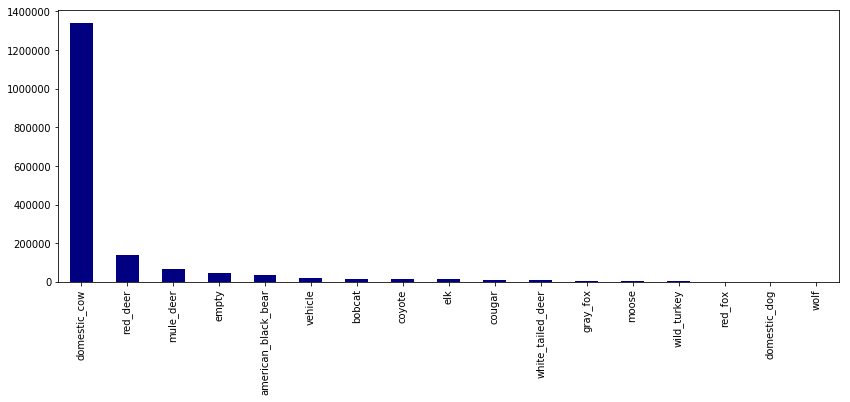


Test set size: 882058


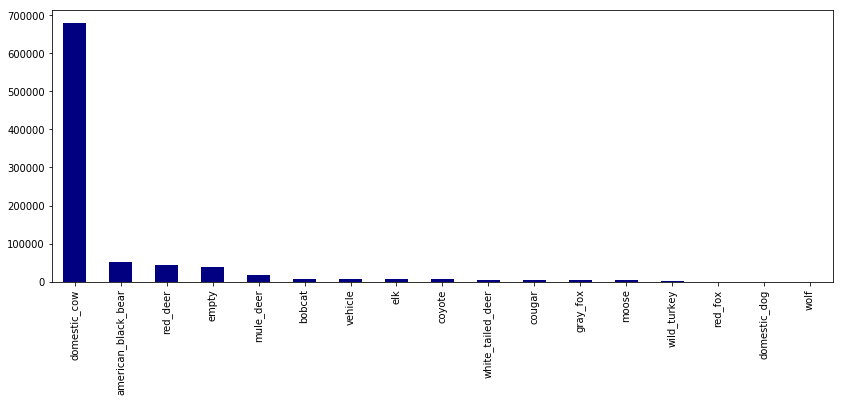

In [11]:
# Empty vs Non-Empty by split
print('Training set size: {}'.format(len(species_train_df)))
species_train_df['category_name'].value_counts().plot.bar(logy=False, figsize=(14,5), color='navy')
plt.show()
print()
print('Test set size: {}'.format(len(species_test_df)))
species_test_df['category_name'].value_counts().plot.bar(logy=False, figsize=(14,5), color='navy')
plt.show()

### Cap the total number of animals and save the output csv

#### Train

In [12]:
max_species_imgs_train = 10000
list_ = []

# Pare down the number of samples for each species in the training set
for key, grp in species_train_df.groupby('category_name'):
    if key == 'empty':
        continue
    else:
        grp = grp.iloc[0:max_species_imgs_train]
        list_.append(grp)
        
species_train_df = pd.concat(list_)

Rows: 115923


,cam_location,id
category_name,,
american_black_bear,182,10000
bobcat,90,10000
cougar,66,9724
coyote,350,10000
domestic_cow,67,10000
domestic_dog,57,476
elk,33,10000
gray_fox,32,6337
moose,68,6098


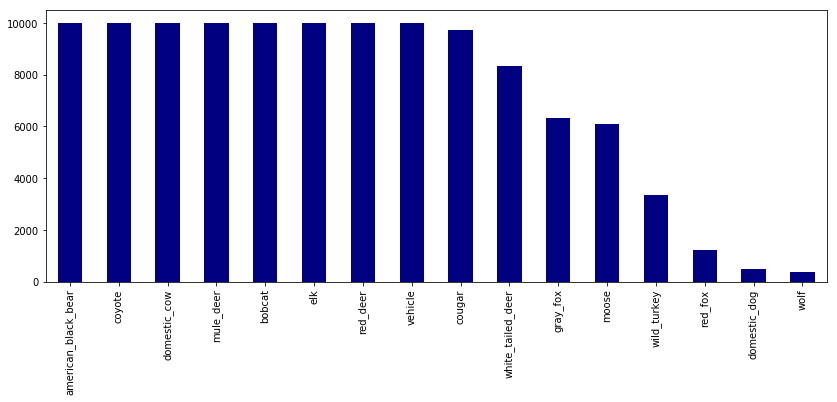

In [13]:
print('Rows: {}'.format(len(species_train_df)))
display(species_train_df.groupby('category_name').agg({'cam_location':pd.Series.nunique, 'id':pd.Series.nunique}))
species_train_df['category_name'].value_counts().plot.bar(logy=False, figsize=(14,5), color='navy');

In [14]:
species_train_df.to_csv("/data/dataframes/speciesTrain.csv", index=False)

#### Test

In [15]:
max_species_imgs_test = 2500
list_ = []

# Pare down the number of samples for each species in the training set
for key, grp in species_test_df.groupby('category_name'):
    if key == 'empty':
        continue
    else:
        grp = grp.iloc[0:max_species_imgs_test]
        list_.append(grp)
        
species_test_df = pd.concat(list_)

Rows: 31833


,cam_location,id
category_name,,
american_black_bear,49,2500
bobcat,42,2500
cougar,29,2500
coyote,139,2500
domestic_cow,35,2500
domestic_dog,22,229
elk,16,2500
gray_fox,15,2500
moose,30,2500


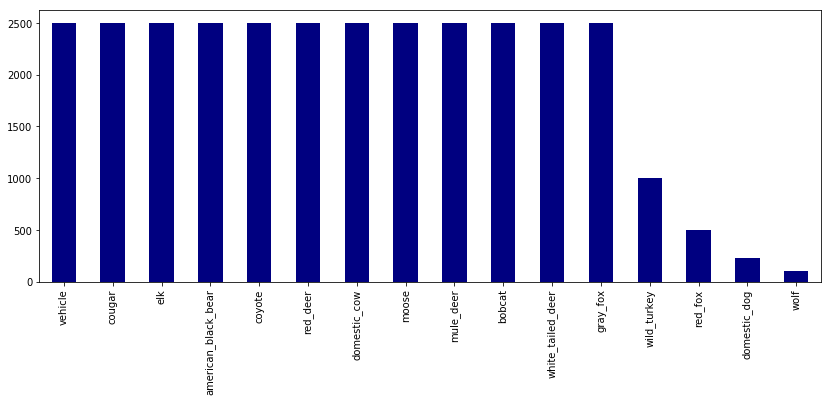

In [16]:
print('Rows: {}'.format(len(species_test_df)))
display(species_test_df.groupby('category_name').agg({'cam_location':pd.Series.nunique, 'id':pd.Series.nunique}))
species_test_df['category_name'].value_counts().plot.bar(logy=False, figsize=(14,5), color='navy');

In [17]:
species_test_df.to_csv("/data/dataframes/speciesTest.csv", index=False)

# Create an inclusive split based on Empty vs Animal

- Cap total photos for over-represented species
- Do *not* filter out minimally represented species
- Remove locations that are entirely empty
- Allow for non-empty locations to avoid filtering out species
- Split into train/val based on location

In [18]:
# Create a copy of the dataframe from before
empty_df = df.copy()

# Remove all traps that only contain a single animal
category_counts = empty_df.groupby(['cam_location'])['category_id'].nunique().reset_index(drop=False)
single_animal_trap_list = list(category_counts[category_counts['category_id']==1]['cam_location'].unique())
empty_df = empty_df[~empty_df['cam_location'].isin(single_animal_trap_list)]

# Remove all traps that do not contain any empty photos
# empty_trap_list = list(df[df['category_name'] == 'empty']['cam_location'].unique())
# empty_df = empty_df[empty_df['cam_location'].isin(empty_trap_list)]

# Remove cameras that are entirely empty
# only_empty_df = empty_df.groupby(['cam_location'])['category_id'].nunique().reset_index(drop=False)
# only_empty_trap_list = list(only_empty_df[only_empty_df['category_id']==1]['cam_location'].unique())
# empty_df = empty_df[~empty_df['cam_location'].isin(only_empty_trap_list)]

# Create an empty vs animal class
empty_df['target'] = empty_df['category_name'].apply(empty_v_animal_label)

# Label the original file path
empty_df['abs_file_path'] = empty_df['file_path'].apply(lambda path: os.path.join('/data/nacti', path))

empty_df.head()

,category_id,id,image_id,file_path,category_name,subfolder,cam_location,target,abs_file_path
0,10,b56989c2-d98a-11e8-969f-000d3a71ec1a,2010_Unit150_Ivan097_img0001.jpg,sub001/2010_Unit150_Ivan097_img0001.jpg,red_deer,sub001,2010_unit150_ivan097,animal,/data/nacti/sub001/2010_Unit150_Ivan097_img000...
1,10,b56989c3-d98a-11e8-969f-000d3a71ec1a,2010_Unit150_Ivan097_img0002.jpg,sub001/2010_Unit150_Ivan097_img0002.jpg,red_deer,sub001,2010_unit150_ivan097,animal,/data/nacti/sub001/2010_Unit150_Ivan097_img000...
2,10,b56989c4-d98a-11e8-969f-000d3a71ec1a,2010_Unit150_Ivan097_img0003.jpg,sub001/2010_Unit150_Ivan097_img0003.jpg,red_deer,sub001,2010_unit150_ivan097,animal,/data/nacti/sub001/2010_Unit150_Ivan097_img000...
3,10,b56989c5-d98a-11e8-969f-000d3a71ec1a,2010_Unit150_Ivan097_img0004.jpg,sub001/2010_Unit150_Ivan097_img0004.jpg,red_deer,sub001,2010_unit150_ivan097,animal,/data/nacti/sub001/2010_Unit150_Ivan097_img000...
4,10,b56989c6-d98a-11e8-969f-000d3a71ec1a,2010_Unit150_Ivan097_img0005.jpg,sub001/2010_Unit150_Ivan097_img0005.jpg,red_deer,sub001,2010_unit150_ivan097,animal,/data/nacti/sub001/2010_Unit150_Ivan097_img000...


In [19]:
empty_df['target'].value_counts()

animal    3033265
empty       96850
Name: target, dtype: int64

In [20]:
# Split into training and test based on the camera location
empty_train_cams, empty_test_cams = train_test_split(empty_df['cam_location'].unique(), test_size=0.3, random_state=42)

# Get the training samples from the specified cams
empty_train_df = empty_df[empty_df['cam_location'].isin(empty_train_cams)] 
empty_train_df = empty_train_df.sample(frac=1, axis=0, random_state=42).reset_index(drop=True) #Shuffle

# Get the test samples from the specified cams
empty_test_df = empty_df[empty_df['cam_location'].isin(empty_test_cams)]
empty_test_df = empty_test_df.sample(frac=1, axis=0, random_state=42).reset_index(drop=True) # Shuffle

Training set size: 2222296


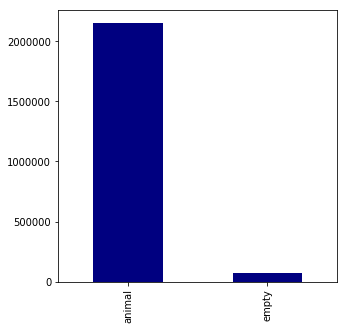

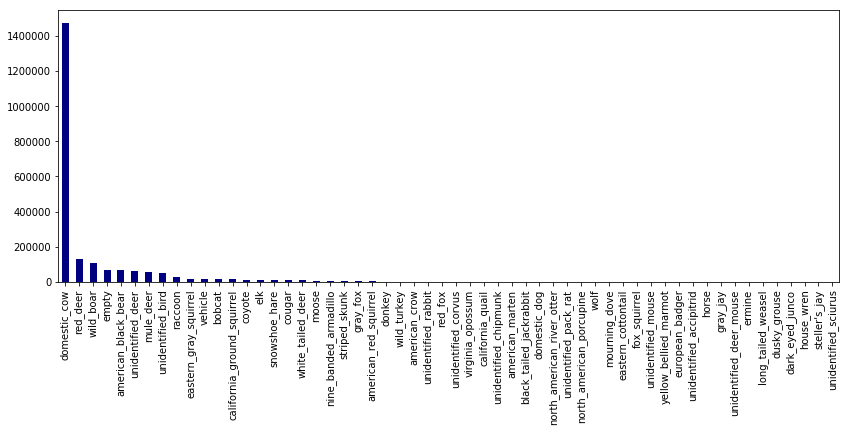


Test set size: 907819


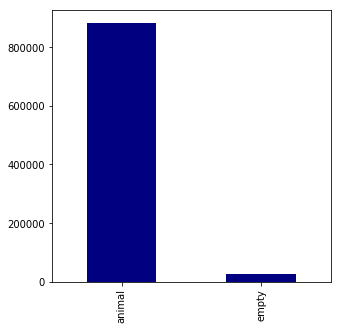

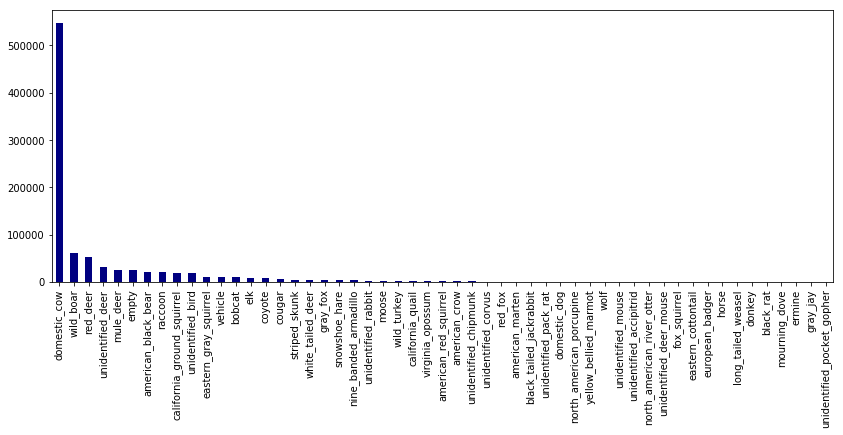

In [21]:
# Evaluate the results of the train-test split

# Empty vs Non-Empty by split
print('Training set size: {}'.format(len(empty_train_df)))
empty_train_df['target'].value_counts().plot.bar(figsize=(5,5), color='navy')
plt.show()
empty_train_df['category_name'].value_counts().plot.bar(logy=False, figsize=(14,5), color='navy')
plt.show()
print()
print('Test set size: {}'.format(len(empty_test_df)))
empty_test_df['target'].value_counts().plot.bar(figsize=(5,5), color='navy')
plt.show()
empty_test_df['category_name'].value_counts().plot.bar(logy=False, figsize=(14,5), color='navy')
plt.show()

### Cap the total number of animals and save the output csv

#### Train

In [22]:
max_species_imgs_train = 2500
list_ = []

# Pare down the number of samples for each species in the training set
for key, grp in empty_train_df.groupby('category_name'):
    if key == 'empty':
        list_.append(grp)
    else:
        grp = grp.iloc[0:max_species_imgs_train]
        list_.append(grp)
        
large_empty_v_animal_train_df = pd.concat(list_)

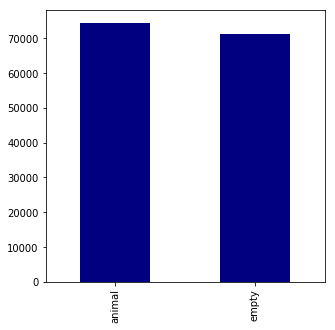

In [23]:
large_empty_v_animal_train_df['target'].value_counts().plot.bar(figsize=(5,5), color='navy')
plt.show()

In [24]:
large_empty_v_animal_train_df.to_csv("/data/dataframes/inclusiveEVATrain.csv", index=False)

#### Test

In [25]:
max_species_imgs_test = 800
list_ = []

# Pare down the number of samples for each species in the training set
for key, grp in empty_test_df.groupby('category_name'):
    if key == 'empty':
        list_.append(grp)
    else:
        grp = grp.iloc[0:max_species_imgs_test]
        list_.append(grp)
        
large_empty_v_animal_test_df = pd.concat(list_)

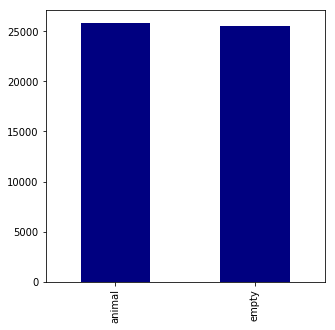

In [26]:
large_empty_v_animal_test_df['target'].value_counts().plot.bar(figsize=(5,5), color='navy')
plt.show()

In [27]:
large_empty_v_animal_test_df.to_csv("/data/dataframes/inclusiveEVATest.csv", index=False)

## Create an exclusive split based on Empty vs Animal

- Cap total photos for over-represented species
- Do *not* filter out minimally represented species
- Remove locations that are entirely empty
- Remove locations that are entirely non-empty as well to avoid bias
- Split into train/val based on location

### Filter out empty, non-empty and single category cams

In [28]:
# Create a copy of the dataframe from before
empty_df = df.copy()

# Remove all traps that only contain a single animal
category_counts = empty_df.groupby(['cam_location'])['category_id'].nunique().reset_index(drop=False)
single_animal_trap_list = list(category_counts[category_counts['category_id']==1]['cam_location'].unique())
empty_df = empty_df[~empty_df['cam_location'].isin(single_animal_trap_list)]

# Remove all traps that do not contain any empty photos
empty_trap_list = list(df[df['category_name'] == 'empty']['cam_location'].unique())
empty_df = empty_df[empty_df['cam_location'].isin(empty_trap_list)]

# Create an empty vs animal class
empty_df['target'] = empty_df['category_name'].apply(empty_v_animal_label)

# Label the original file path
empty_df['abs_file_path'] = empty_df['file_path'].apply(lambda path: os.path.join('/data/nacti', path))

empty_df.head()

,category_id,id,image_id,file_path,category_name,subfolder,cam_location,target,abs_file_path
329793,47,b6918e65-d98a-11e8-969f-000d3a71ec1a,ACAM201_100RECNX_IMG_0001.JPG,sub033/ACAM201_100RECNX_IMG_0001.JPG,white_tailed_deer,sub033,acam201,animal,/data/nacti/sub033/ACAM201_100RECNX_IMG_0001.JPG
329794,47,b6918e66-d98a-11e8-969f-000d3a71ec1a,ACAM201_100RECNX_IMG_0002.JPG,sub033/ACAM201_100RECNX_IMG_0002.JPG,white_tailed_deer,sub033,acam201,animal,/data/nacti/sub033/ACAM201_100RECNX_IMG_0002.JPG
329795,47,b6918e67-d98a-11e8-969f-000d3a71ec1a,ACAM201_100RECNX_IMG_0003.JPG,sub033/ACAM201_100RECNX_IMG_0003.JPG,white_tailed_deer,sub033,acam201,animal,/data/nacti/sub033/ACAM201_100RECNX_IMG_0003.JPG
329796,16,b6918e68-d98a-11e8-969f-000d3a71ec1a,ACAM201_100RECNX_IMG_0004.JPG,sub033/ACAM201_100RECNX_IMG_0004.JPG,empty,sub033,acam201,empty,/data/nacti/sub033/ACAM201_100RECNX_IMG_0004.JPG
329797,16,b6918e69-d98a-11e8-969f-000d3a71ec1a,ACAM201_100RECNX_IMG_0005.JPG,sub033/ACAM201_100RECNX_IMG_0005.JPG,empty,sub033,acam201,empty,/data/nacti/sub033/ACAM201_100RECNX_IMG_0005.JPG


In [29]:
empty_df['target'].value_counts()

animal    121135
empty      96850
Name: target, dtype: int64

### Split and shuffle the data by camera location

In [30]:
# Split into training and test based on the camera location
empty_train_cams, empty_test_cams = train_test_split(empty_df['cam_location'].unique(), test_size=0.3, random_state=42)

# Get the training samples from the specified cams
empty_train_df = empty_df[empty_df['cam_location'].isin(empty_train_cams)] 
empty_train_df = empty_train_df.sample(frac=1, axis=0, random_state=42).reset_index(drop=True) #Shuffle

# Get the test samples from the specified cams
empty_test_df = empty_df[empty_df['cam_location'].isin(empty_test_cams)]
empty_test_df = empty_test_df.sample(frac=1, axis=0, random_state=42).reset_index(drop=True) # Shuffle

### Evaluate the results of the train-test split

Training set size: 169821


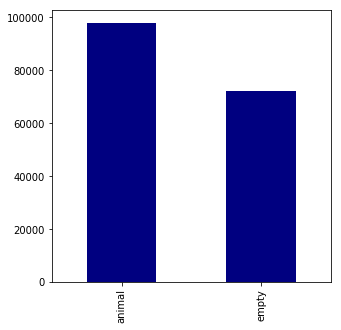

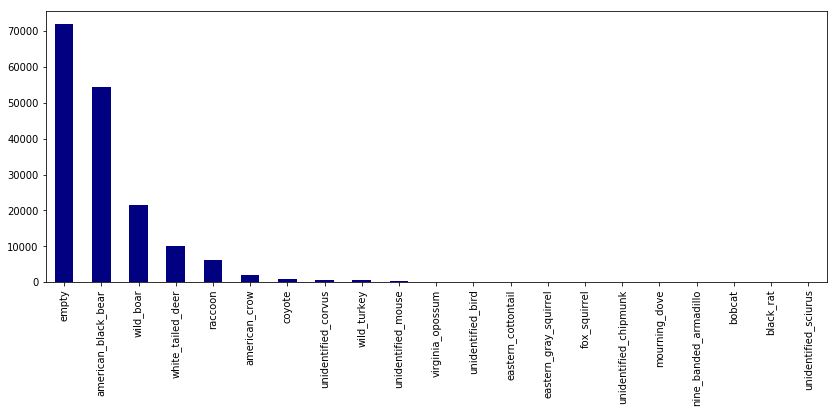


Test set size: 48164


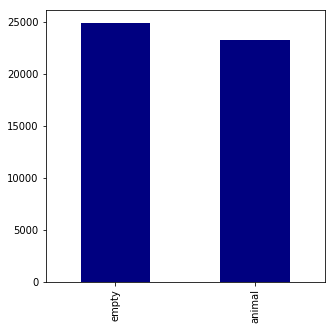

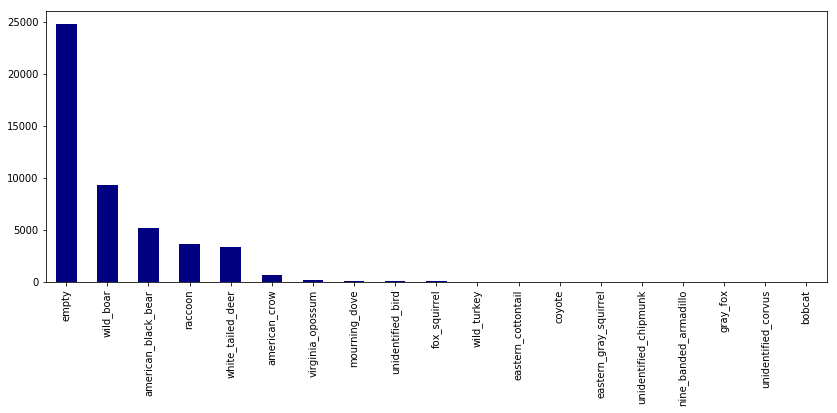

In [31]:
# Empty vs Non-Empty by split
print('Training set size: {}'.format(len(empty_train_df)))
empty_train_df['target'].value_counts().plot.bar(figsize=(5,5), color='navy')
plt.show()
empty_train_df['category_name'].value_counts().plot.bar(logy=False, figsize=(14,5), color='navy')
plt.show()
print()
print('Test set size: {}'.format(len(empty_test_df)))
empty_test_df['target'].value_counts().plot.bar(figsize=(5,5), color='navy')
plt.show()
empty_test_df['category_name'].value_counts().plot.bar(logy=False, figsize=(14,5), color='navy')
plt.show()

### Cap the total number of animals and save the output csv

#### Train

This is not necessary as the empty/animal classes are reasonably well balanced on their own

In [32]:
# max_species_imgs_train = 2500
# list_ = []

# # Pare down the number of samples for each species in the training set
# for key, grp in empty_train_df.groupby('category_name'):
#     if key == 'empty':
#         list_.append(grp)
#     else:
#         grp = grp.iloc[0:max_species_imgs_train]
#         list_.append(grp)
        
# small_empty_v_animal_train_df = pd.concat(list_)

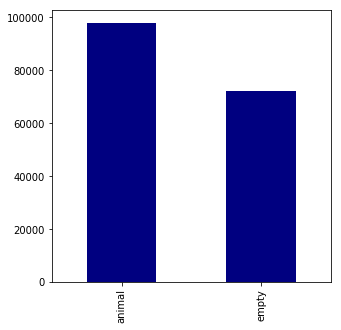

In [33]:
empty_train_df['target'].value_counts().plot.bar(figsize=(5,5), color='navy')
plt.show()

In [34]:
empty_train_df.to_csv("/data/dataframes/exclusiveEVATrain.csv", index=False)

#### Test

This is not necessary as the empty/animal classes are reasonably well balanced on their own

In [35]:
# max_species_imgs_test = 800
# list_ = []

# # Pare down the number of samples for each species in the training set
# for key, grp in empty_test_df.groupby('category_name'):
#     if key == 'empty':
#         list_.append(grp)
#     else:
#         grp = grp.iloc[0:max_species_imgs_test]
#         list_.append(grp)
        
# large_empty_v_animal_test_df = pd.concat(list_)

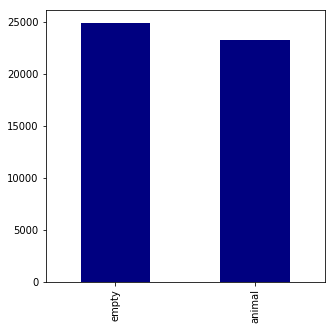

In [36]:
empty_test_df['target'].value_counts().plot.bar(figsize=(5,5), color='navy')
plt.show()

In [37]:
empty_test_df.to_csv("/data/dataframes/exclusiveEVATest.csv", index=False)